# Seminar 6. Feature selection & cross-validation pitfalls
Mikhail Belyaev

# Final project 

Two options:
   1. A problem related to your research or innovation activities
   2. A real life problems selected by course instructors (a dataset from UCI or other sources);
    
- You can form groups up to **3** persons. 
- Please, describe the contribution of each person in the Jupyter notebook.

Final projects deliverables:
 - Prepare a presentation using Jupyter notebook and submit it to Canvas
     * Submission Deadline: Thu, 25, 12:30 Moscow time
 - Present your results to course instructors and other students (using the submitted jupyter notebook). 
 - Two possible timeslots for the presentation 
     * Thu, 25
     * Fri, 26
     
Monday, 22 is allocated for consultations.

**Actions required**
 - If you select (1), please prepare a brief description (up to 5-6 sentences) how do you want to use Machine Learning in your project.
 - If you want to form a team, please inform us (you can write a single email, but please add your teammate to the copy of your letter). 
 - If you want to present your work on specific day, include this request in your letter.

**Deadline** - Friday, Oct 19, 12:30 Moscow time. 

Please, send the required information to me (m.belyaev@skoltech.ru) **and** Maxim (m.panov@skoltech.ru). 

If you (or your teammate) don't send us any information, we will assign a problem to you individually.

# Seminar 5 revision

![alt text](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png "Bias-variance tradeoff")

In [3]:
from xgboost import XGBClassifier
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Which XGBoost parameters are the most import ones? 

How do these parameters affect model complexity?

# Seminar 6

** 6. Features selection**
 - Effective dimensionality reduction;
 - Feature selection approaches: wrappers, filters, embedded methods;
 - Cross-validation pitfals.

# Selection of important features

## Feature selection 

### There are three main groups of feature selection methods:
 - filters
 - wrappers
 - embedded methods 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
% pylab inline

Populating the interactive namespace from numpy and matplotlib


## Filters

- estimate an importance score for each feature
- select K most important one
- there are a lot of different ways to calculate feature importances
- Example: http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection 

### Example 1. Good classification performance, but low statistical score

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

Generate a simple dataset

In [6]:
def get_dataset1():
    X = np.random.rand(200, 2)
    X[:100, 0] += 1
    X[100:150, 0] += 2
    X[100:, 1] += 0.1
    y = np.concatenate([np.zeros(100), np.ones(100)])
    return X, y

X, y = get_dataset1()

/home/mikhail/.anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


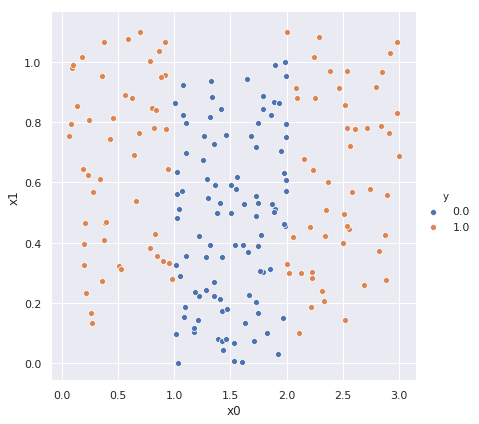

In [7]:
def plot_data(X, y):
    x_cols = ['x{}'.format(i) for i in range(X.shape[1])]
    df = pd.DataFrame(np.hstack((X, y[:, np.newaxis])), columns=x_cols+['y'])
    if len(x_cols) == 2:
        sns.pairplot(df, hue='y', x_vars='x0', y_vars='x1', size=6)
    else:
        sns.pairplot(df, hue='y', vars=x_cols)
plot_data(X, y)

In [8]:
# ANOVA
selector = SelectKBest(f_classif, 1)
selector.fit(X, y)
# SelectKBest just selects the specified number of features with the highest scores 
print(X.shape) 
X_reduced = selector.transform(X)
print(X_reduced.shape)
# and what about scores?
print(selector.scores_)
# it selects the wrong variable!

(200, 2)
(200, 1)
[1.19364733e-02 1.69800752e+01]


In [9]:
# mutial information is another way to estimate scores ...
selector = SelectKBest(mutual_info_classif, 1)
selector.fit(X, y)
print(selector.scores_)
# and it works in that case

[0.66822648 0.04555259]


### Example 2. Univariate stats doesn't catch bivariate dependencies

In [11]:
def get_dataset2(shift=0.2):
    X = np.random.rand(1000, 3)
    X = X[np.abs(X[:, 1] - X[:, 0]) < 0.22]
    X = X[np.abs(X[:, 1] - X[:, 0]) > 0.02]
    y = X[:, 1] > X[:, 0] 
    X[y, 2] += shift
    return X, y
X, y = get_dataset2()

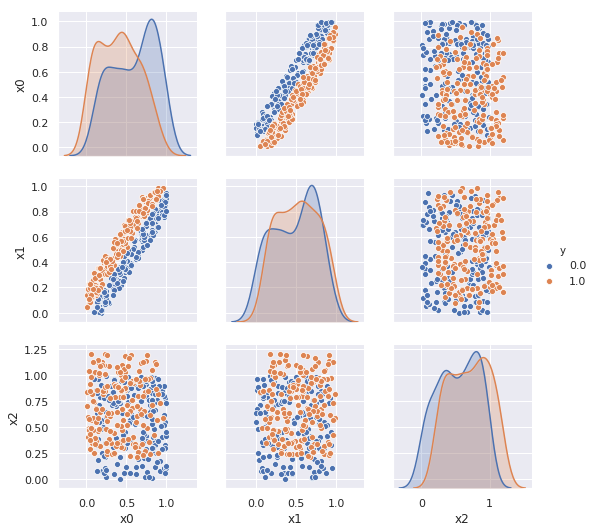

In [12]:
plot_data(X, y) 

In [13]:
print(SelectKBest(f_classif, 2).fit(X, y).scores_)
print(SelectKBest(mutual_info_classif, 2).fit(X, y).scores_)
# both univariate methods fail

[46.38791398  2.47482508 30.97958868]
[0.08411564 0.00639075 0.13688624]


##  Wrappers
 - a greedy alrogithm for feature adding and/or deletion
 - there are a lot of different stratigies (starting points, criteria, etc)
 - an example http://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination 

In [30]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


svc = make_pipeline(StandardScaler(), SVC(kernel="linear"))
# svc = SVC(kernel="linear", C=1e10)
rfe = RFE(estimator=svc, n_features_to_select=2, step=1)

X2 = X.copy()
X2[:, 0] = X2[:, 0] / 1000

svc.fit(X2, y)
# print(svc.coef_)
print(svc.steps[1][1].coef_)

[[-5.03685835  4.66311699  0.18193894]]


[1 1 2]


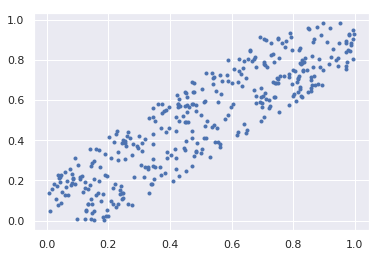

In [16]:
rfe.fit(X, y)
print(rfe.ranking_)
# rank 1 means that these features were selected

X_transformed = rfe.transform(X)
plt.plot(X_transformed[:, 0], X_transformed[:, 1], '.')

## Embedded 
- features are selected automatically as a part of the learning process 
- an example - linear models with the L1 regularization

![alt text](https://1.bp.blogspot.com/-tXq6Nl2lcNg/V3qzttiZ4sI/AAAAAAAAN_M/6nmjgwydWJUy5Kqt9gFg2Nb12BCTcD4ogCLcB/s1600/LASSO.png  "Embedded feature selection methods")

In [36]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', C=0.1)
clf.fit(X, y)
print(clf.coef_)

[[-0.89194872  0.          0.64671118]]


L1-penalty based approaches are a cool class of methods, but in case of correlated variables it can drop relevant features

Let us make the last component fully irrelevant and try a L1-based method again

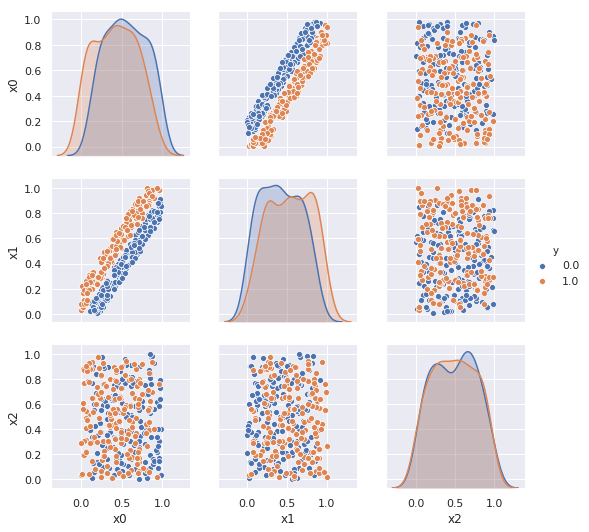

In [40]:
X, y = get_dataset2(shift=0)
df = pd.DataFrame(np.hstack((X, y[:, np.newaxis])), columns=['x0', 'x1', 'x2', 'y'])
sns.pairplot(df, hue='y', vars=['x0', 'x1', 'x2'])

In [41]:
clf = LogisticRegression(penalty='l1', C=0.2)
clf.fit(X, y)
print(clf.coef_)

[[-8.28875293  8.23194958  0.        ]]


### Feature selection: a small example

#### TODO: 
 - load an anonimized dataset from dataset3.csv
 - estimate the 10 most important features (using f_classif)
 - perform cross-validation & estimate classification quality

In [45]:
import pandas as pd
def get_dataset3():
    # insert your code here
    data = pd.read_csv('./dataset3.csv')
    X = data.iloc[:,:-1]
    y = data.iloc[:, -1]
    return X, y
X, y = get_dataset3()

X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x4863,x4864,x4865,x4866,x4867,x4868,x4869,x4870,x4871,x4872
0,0.415565,-0.144159,1.498688,0.843930,1.736326,-1.048023,-0.567444,-1.568540,-0.454729,-1.238958,...,-0.136349,0.664779,-0.361853,1.577162,1.197755,-1.635533,0.618030,0.560045,-1.120412,0.205123
1,0.759752,-1.270058,-0.463532,1.701806,0.199459,-1.055586,-0.611728,0.491234,0.212398,-0.831789,...,-0.926783,1.757657,0.607199,-0.993059,0.041725,1.751181,-1.324243,1.355293,-0.618517,-0.687989
2,0.575741,0.569141,0.232469,1.312427,1.105427,0.405529,-1.508660,-0.951836,0.365138,-0.743987,...,0.050227,1.539508,0.262433,0.785780,-0.615320,1.104032,-1.561042,0.448165,-1.010801,1.659146
3,-0.409274,0.632820,0.421591,0.540943,-0.669616,-0.047474,1.758110,-1.602530,2.352296,-0.344142,...,-0.104558,-1.625126,-0.413647,-1.991743,-0.891705,-1.418683,-1.817538,-1.139779,-0.699888,1.597597
4,0.888073,-2.458116,-0.218338,0.346368,-0.262323,0.520068,-0.251153,1.320535,1.899126,0.906623,...,0.857870,-1.730599,-1.181402,0.322079,-0.329885,-0.443631,0.187749,1.590329,1.855634,-1.824229


In [46]:
# it's an anonimized dataset with standatized features
print('Data shape is {}'.format(X.shape))
print('Class 0 size is {}'.format(sum(y==0)))
print('Class 1 size is {}'.format(sum(y==1)))
X.head(5)

Data shape is (121, 4873)
Class 0 size is 71
Class 1 size is 50


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x4863,x4864,x4865,x4866,x4867,x4868,x4869,x4870,x4871,x4872
0,0.415565,-0.144159,1.498688,0.843930,1.736326,-1.048023,-0.567444,-1.568540,-0.454729,-1.238958,...,-0.136349,0.664779,-0.361853,1.577162,1.197755,-1.635533,0.618030,0.560045,-1.120412,0.205123
1,0.759752,-1.270058,-0.463532,1.701806,0.199459,-1.055586,-0.611728,0.491234,0.212398,-0.831789,...,-0.926783,1.757657,0.607199,-0.993059,0.041725,1.751181,-1.324243,1.355293,-0.618517,-0.687989
2,0.575741,0.569141,0.232469,1.312427,1.105427,0.405529,-1.508660,-0.951836,0.365138,-0.743987,...,0.050227,1.539508,0.262433,0.785780,-0.615320,1.104032,-1.561042,0.448165,-1.010801,1.659146
3,-0.409274,0.632820,0.421591,0.540943,-0.669616,-0.047474,1.758110,-1.602530,2.352296,-0.344142,...,-0.104558,-1.625126,-0.413647,-1.991743,-0.891705,-1.418683,-1.817538,-1.139779,-0.699888,1.597597
4,0.888073,-2.458116,-0.218338,0.346368,-0.262323,0.520068,-0.251153,1.320535,1.899126,0.906623,...,0.857870,-1.730599,-1.181402,0.322079,-0.329885,-0.443631,0.187749,1.590329,1.855634,-1.824229


#### The number of features is too large, so it seems to be a good idea to start with feature selection

In [47]:
# TODO fit SelectKBest and select 10 best features
selector = SelectKBest()

# SelectKBest just selects the specified number of features with the highest scores 
selector.fit(X, y)
print(X.shape)
X_reduced = selector.transform(X)
print(X_reduced.shape)

(121, 4873)
(121, 10)


#### Now we have a reasonable number of features and can estimate classification accuracy 

In [50]:
# TODO apply logistic regression to the reduced data set and estimate accuracy using cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
cross_val_score(LogisticRegression(), X_reduced, y)

array([0.73170732, 0.80487805, 0.8974359 ])

In [51]:
# TODO: what if we skip the feature selection step?
cross_val_score(LogisticRegression(), X, y)

array([0.53658537, 0.53658537, 0.58974359])

#### So, we've obtained a great result using feature selection! Probably, too good to be true ...

Sanity check: randomly shuffle labels

In [52]:
y_random = y.copy() 
np.random.shuffle(y_random)

In [54]:
# TODO: estimate accuracy of pipeline 
selector = SelectKBest()
selector.fit(X, y_random)
print(X.shape)
X_reduced = selector.transform(X)
print(X_reduced.shape)

np.mean(cross_val_score(LogisticRegression(), X_reduced, y_random, cv=5))

(121, 4873)
(121, 10)


0.8256666666666668

#### There is a mistake somewhere ...

#### We used *all* available data for feature selection!

### How to do a multistep analysis in a correct way? Use pipeline!

In [55]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(SelectKBest(), 
                      LogisticRegression())
scores = cross_val_score(pipe, X, y_random, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))

scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.2f} +- {:0.2f}'.format(np.mean(scores), np.std(scores)))

Accuracy of classification is 0.53 +- 0.07
Accuracy of classification is 0.56 +- 0.07


### Feature importances: ensembles of trees

Ensembles of trees are usually based on a large set of features, and it's hardly possible to represent such complex models by simple equations. However, there are two other meaningful properties of predictive models which can be used to interpret results. 

- The first useful property is an ability to automatically find important combinations of features and then visualize model predictions as a function of these combinations. The boosted trees models don't allow to create such figures, and the only opportunity is to plot pairwise interactions of the features. 

 - Another desired property of predictive models is an ability to estimate the importance of each feature. Unfortunately, boosted trees as well as other tree-based ensemble methods tend to overestimate importance of actually unimportant features if dataset contains highly correlated features, see: 
 *Auret, L. & Aldrich, C. Empirical comparison of tree ensemble variable importance mea-sures. Chemometrics and Intelligent Laboratory Systems105,157–170 (2011)*

## A sklearn example of embedded feature importances

Feature ranking:


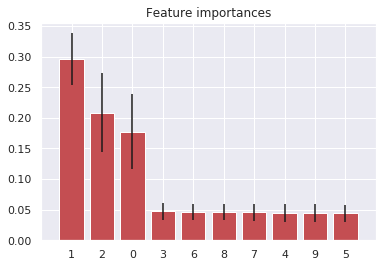

In [57]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### TODO: add some correlated features and check the result (keyword n_redundant of make_classification)

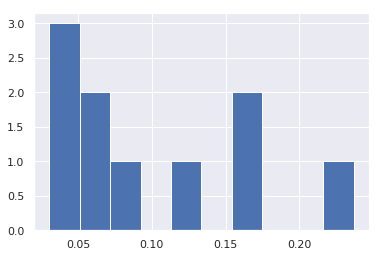

In [59]:
#template to estimate XGB importance
clf = XGBClassifier()
clf.fit(X, y)
importances = clf.feature_importances_
plt.hist(importances);

# Another possible pitfall: selection of hyperparameters & grid search 

In [60]:
def f_poly(x, coefs):
    summands = [x**(power+1) * coef for power, coef in enumerate(coefs)]
    return np.array(summands).sum(0)

def get_function(coefs=None):
    if coefs is None:
        coefs = [1, -0.5, -1, 0.6]
    return lambda x: f_poly(x, coefs)

def get_dataset4(f, sample_size, noise_std=0.1):
    X = np.random.rand(sample_size, 1) * 2 - 1
    y = f(X)
    y += np.random.randn(*y.shape) * noise_std
    return X, y

def plot_dataset4(f, X=None, y=None, regr=None):
    X_plot = np.linspace(-1, 1, 100)[:, np.newaxis]
    plt.plot(X_plot, f(X_plot), label='True function')
    if X is not None and y is not None:
        plt.plot(X, y, '.r')
    if regr is not None:
        plt.plot(X_plot, regr.predict(X_plot), label='Prediction')
    plt.legend(loc='best')
    plt.ylim([-0.8, 0.6])

#### Lets generate a dataset

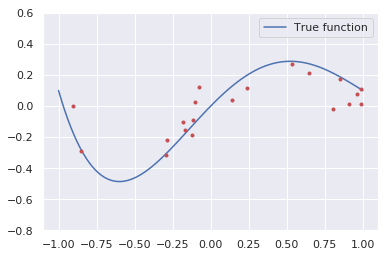

In [61]:
f = get_function()
X, y = get_dataset4(f, 20)
X_test, y_test = get_dataset4(f, 100)
plot_dataset4(f, X, y)

#### We'll use a polinomial model to fit the data and ridge regression to estimate coefficients of the model

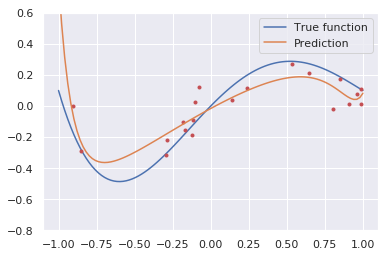

In [63]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
regr = make_pipeline(PolynomialFeatures(20), Ridge(alpha=0.1))
regr.fit(X, y)
plot_dataset4(f, X, y, regr)

In [64]:
from sklearn.metrics.regression import mean_squared_error as mse

def get_errors(regr, X, y):
    y_predicted = regr.predict(X)
    mse(y, y_predicted)**0.5
    return mse(y, y_predicted)**0.5
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))

Root mean squared error is 0.16730000736965073


### Bias-variance tradeoff

![alt text](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png "Bias-variance tradeoff")

### We can use regularization to control model parameters

Root mean squared error is 0.14703339494790382


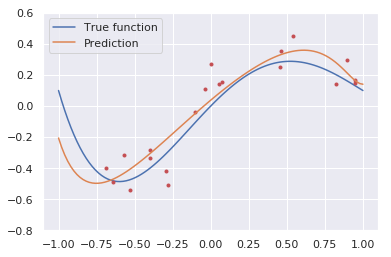

In [71]:
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(1e-1))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

In [ ]:
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(1e9))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

In [ ]:
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(0.1))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

#### So, quality depends on regularization parameter significantly 

### How to select model parameters?

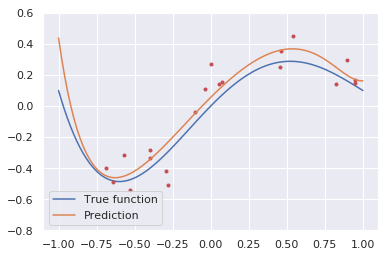

In [74]:
from sklearn.model_selection import GridSearchCV
# our model is a pipeline, so we have to use a special format to specify parameters
# 
parameters = {'ridge__alpha':10**np.linspace(-5, 5, 21)}
regr = make_pipeline(PolynomialFeatures(20), Ridge())
regr_grid = GridSearchCV(regr, parameters)
regr_grid.fit(X, y)

plot_dataset4(f, X, y, regr_grid)

### But what is we have more than one parameter to adjust?

In [97]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
parameters = {'learning_rate': [0.001, 0.005, 0.01, 0.025, 0.05, 0.1],
              'max_depth': range(1, 10),
              'n_estimators': [5, 10, 20, 35, 50, 100],
             }
clf_grid = GridSearchCV(clf, parameters, n_jobs=-1, verbose=True)
# we use dataset 3 again
X, y = get_dataset3()
clf_grid.fit(X, y) 

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  8.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.025, 0.05, 0.1], 'max_depth': range(1, 10), 'n_estimators': [5, 10, 20, 35, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [98]:
best_score_ = clf_grid.best_score_
print(best_score_)
best_params = clf_grid.best_params_
print(best_params)

0.5950413223140496
{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 35}


### An error with a fixed parameters is a random variable

Root mean squared error is 0.16429761702373488


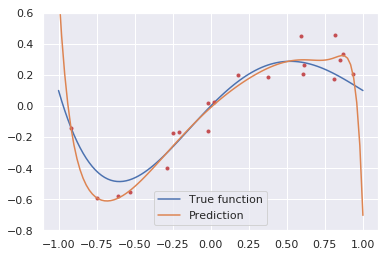

In [96]:
# TODO: execute this cell multiple times and track function's behavior and the error
X, y = get_dataset4(f, 20)
regr = make_pipeline(PolynomialFeatures(20), Ridge(1e-4))
regr.fit(X, y)
print('Root mean squared error is {}'.format(get_errors(regr, X_test, y_test)))
plot_dataset4(f, X, y, regr)

### We can plot distribution of erros

#### for a single model ...

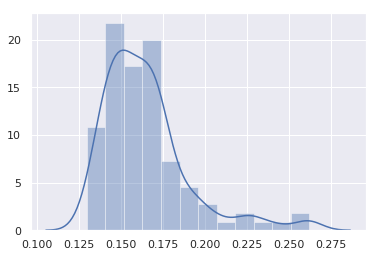

#### ... and for several model

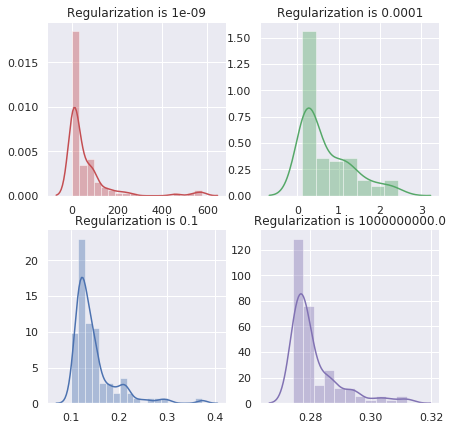

### Now check the optimal parameters which were found by GridSearch

In [99]:
from sklearn.model_selection import KFold
scores = []
X, y = get_dataset3()
for i in range(100):
    clf = GradientBoostingClassifier(**best_params)
    cv = KFold(random_state=i, shuffle=True)
    score = cross_val_score(clf, X, y, cv=cv, n_jobs=-1).mean()
    scores.append(score)

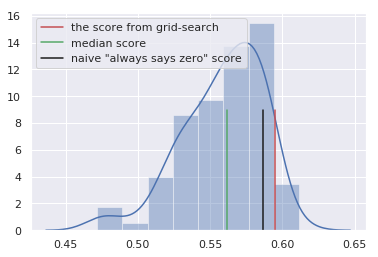

In [100]:
sns.distplot(scores)
# sns.distplot([best_score_]*100)
plt.plot([best_score_] * 10 , range(10), 'r', label='the score from grid-search')
plt.plot([np.median(scores)] * 10 , range(10), 'g', label='median score')
plt.plot([np.mean(y==0)] * 10 , range(10), 'k', label='naive "always says zero" score')
plt.legend()

##### The grid-search score is better than the highest possible accuracy level. 

### The problem is that GridSearchCV gives you a single number from the whole distribution. Due to a greedy nature of the algorithm, this score is usually too optimistic

## Take-away messages

 - Ideally, use an independent test set 
 - If you use multistep anysis always chain these steps into a single sklearn pipeline
 - As a sanity check, you can feed to your analysis random variables and compare the obrained results with the expected quality of random classification
 - Do not trust GridSearchCV results, always re-check the optimal comination of parameters